# SPEKF implementation

In [178]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
gamma_hat = 0.2
omega_hat = 0.2
b_hat = 0.2
d_gamma = 0.1
d_omega = 0.1
d_b = 0.1
sigma_u = 0.1
dt = 0.01


In [179]:

# State transition function
def f_int(x):
    u_real, u_imag, gamma, omega, b = x
    u = u_real + 1j * u_imag
    du_dt = (-(gamma + gamma_hat) + 1j * (omega + omega_hat)) * u + (b + b_hat)
    dgamma_dt = -d_gamma * gamma
    domega_dt = -d_omega * omega
    db_dt = -d_b * b
    return np.array([du_dt.real, du_dt.imag, dgamma_dt, domega_dt, db_dt] + 0.1 * np.random.normal(size=5))

# State transition function
def f(x, mask = -1):
    if mask>=0:
        masked = np.ones(5)
        masked[mask] = 0
        out =  f_int(x) * masked
    else:
        out =  f_int(x)
    return out





# Jacobian of the state transition function
def jacobian_f(x):
    u_real, u_imag, gamma, omega, _ = x
    return np.array([
        [-gamma, omega + omega_hat, u_real, -u_imag, 1],
        [-omega - omega_hat, -gamma, u_imag, u_real, 0],
        [0, 0, -d_gamma, 0, 0],
        [0, 0, 0, -d_omega, 0],
        [0, 0, 0, 0, -d_b]
    ])

# Extended Kalman Filter implementation
def ekf_predict(x, P, Q):
    F = jacobian_f(x)
    x_pred = f(x) * dt + x  # Euler integration
    P_pred = F @ P @ F.T * dt**2 + Q  # Process noise
    return x_pred, P_pred

def ekf_update(x_pred, P_pred, z, R, H):
    y = z - x_pred[0]  # Measurement residual (only real and imag parts of u are observed)
    S = H @ P_pred @ H.T + R  # Residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x_upd = x_pred + K @ y
    P_upd = P_pred - K @ H @ P_pred
    return x_upd, P_upd


In [182]:

# Initial state and covariance
x_true = np.array([1.0, 0.0, 0.5, 0.5, 0.5])  # True state (real part, imag part, gamma, omega, b)
# x_est = x_true.copy()  # Estimated state
# change estimated state
x_est =  np.array([1.0, 0.0, 0.5, 0.5, 0.5])  #  # Estimated state
P = np.eye(5) * 0.1

# Process and measurement noise covariance
Q = np.eye(5) * 0.2
R = np.eye(1) * 0.1
H = np.array([[1, 0, 0, 0, 0]])  # Measurement matrix

# Variables for storing the states
true_states = []
estimated_states = []

# EKF loop
for step in range(40000):
    t = step * dt
    # Predict
    x_pred, P_pred = ekf_predict(x_est, P, Q)
    
    # Simulate measurement (only real and imag parts of u are observed with noise)
    z = x_true[0] + np.random.multivariate_normal(np.zeros(1), R)
    
    # Update
    x_est, P = ekf_update(x_pred, P_pred, z, R, H)
    
    # Update true state (for simulation purposes)
    # x_true = f(x_true) * dt + x_true
    # regime switch
    # Update true state (for simulation purposes)
    if t >= 2000:
        x_true = f(x_true, mask=3) * dt + x_true
    elif t >= 1000:
        x_true = f(x_true, mask=2) * dt + x_true
    else:
        x_true = f(x_true, -1) * dt + x_true
    
    # Store the states for later plotting
    true_states.append(x_true.copy())
    estimated_states.append(x_est.copy())


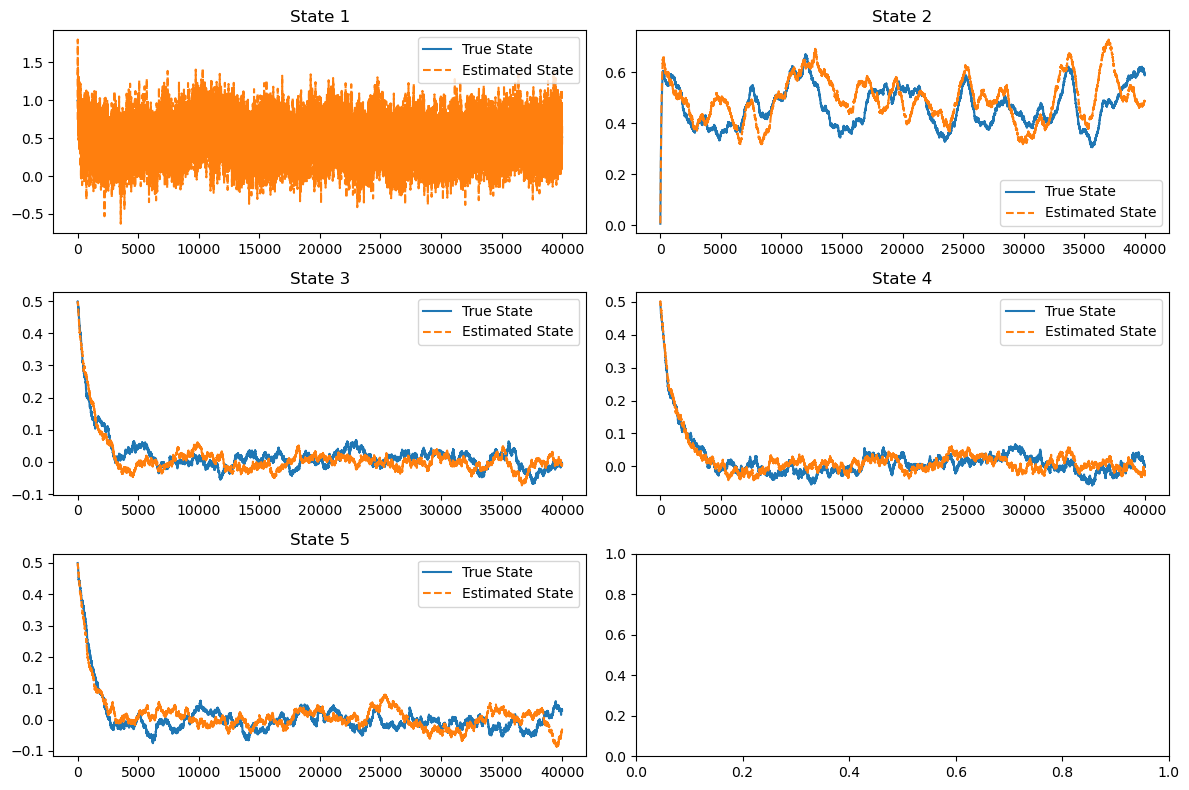

In [183]:
# Convert lists to numpy arrays for easier indexing
true_states = np.array(true_states)
estimated_states = np.array(estimated_states)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i in range(5):
    row, col = divmod(i, 2)
    axs[row, col].plot(true_states[:, i], label='True State')
    axs[row, col].plot(estimated_states[:, i], label='Estimated State', linestyle='--')
    axs[row, col].set_title(f'State {i+1}')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

